In [1]:
import numpy as np
import pandas as pd
import pickle
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
local_stringdb = 'D:/study/thesis/project/HBDM-main/data/nn_data/stringdb/'
# load local STRING database and names
df = pd.read_csv(local_stringdb+'9606.protein.info.v12.0.txt', sep='\t', header=0, usecols=['#string_protein_id', 'preferred_name'])
df['preferred_name'] = df['preferred_name'].str.upper()
stringId2name = df.set_index('#string_protein_id')['preferred_name'].to_dict()
name2stringId = df.set_index('preferred_name')['#string_protein_id'].to_dict()
df = pd.read_csv(local_stringdb+'9606.protein.aliases.v12.0.txt', sep='\t', header=0, usecols=['#string_protein_id', 'alias']).drop_duplicates(['alias'], keep='first')
df['alias'] = df['alias'].str.upper()
aliases2stringId = df.set_index('alias')['#string_protein_id'].to_dict()

#string_score_transform = lambda x: -np.log(x/1000)

graph_df = pd.read_csv(local_stringdb+'9606.protein.physical.links.detailed.v12.0.txt', sep=' ', header=0).convert_dtypes().replace(0, float('nan'))
#network['combined_score'] = network['combined_score'].apply(string_score_transform)
graph_df = graph_df[['protein1', 'protein2','combined_score']]

In [4]:
len(graph_df)

1477610

In [5]:
graph_df = graph_df.sort_values(by='combined_score',ascending=True)

In [6]:

proteins = sorted(list(set(graph_df['protein1'].tolist())|set(graph_df['protein2'].tolist())))
gene2node = {value: index for index, value in enumerate(proteins)}
 
file_path = r'D:\study\thesis\project\HBDM-main\data\datasets\ppi\ppi_index.pkl'
# Serialize and save the Tensor to the file
with open(file_path, 'wb') as file:
    pickle.dump(gene2node, file)
# Close the file
file.close()

In [7]:
graph_df['node1']=graph_df['protein1'].map(gene2node)
graph_df['node2']=graph_df['protein2'].map(gene2node)

In [8]:
G = nx.from_pandas_edgelist(graph_df, source='node1', target='node2', edge_attr='combined_score', create_using=nx.Graph)


In [24]:
# Create a random network with 100 nodes
# Parameters
num_nodes = 19000
avg_degree = 78

# Calculate the probability of edge creation
probability = avg_degree / (num_nodes - 1)

# Create the random graph using the Erdős-Rényi model
random_graph = nx.erdos_renyi_graph(num_nodes, probability)

# Create a scale-free network with 19,000 nodes
scale_free_network = nx.scale_free_graph(n=num_nodes)

In [30]:
graph_df

,protein1,protein2,combined_score
0,9606.ENSP00000000233,9606.ENSP00000257770,311
1,9606.ENSP00000000233,9606.ENSP00000226004,161
2,9606.ENSP00000000233,9606.ENSP00000434442,499
3,9606.ENSP00000000233,9606.ENSP00000262455,531
4,9606.ENSP00000000233,9606.ENSP00000303145,499
...,...,...,...
1477605,9606.ENSP00000501317,9606.ENSP00000444357,292
1477606,9606.ENSP00000501317,9606.ENSP00000296785,962
1477607,9606.ENSP00000501317,9606.ENSP00000361930,195
1477608,9606.ENSP00000501317,9606.ENSP00000370745,188


In [33]:
if G.degree(weight="weight") !=G.degree():
    print('yes')

yes


In [34]:

def plot_degree_distribution(name, G, use_weight=False):
    """
    Plot the degree distribution of a graph.

    Parameters:
    - G: NetworkX graph
    - use_weight: Boolean, whether to consider edge weights in the degree calculation
    """

    # Compute the degree distribution
    if use_weight:
        print('weight')
        degree_sequence = sorted([d for n, d in G.degree(weight="weight")], reverse=True)
    else:
        degree_sequence = sorted([d for n, d in G.degree()], reverse=True)

    degree_counts = nx.degree_histogram(G)

    # Convert counts to fractions
    num_nodes = len(G.nodes)
    degree_fraction = [count / num_nodes for count in degree_counts]

    # Plot the degree distribution on a log-log scale
    plt.loglog(range(len(degree_fraction)), degree_fraction, 'o', markersize=5)
    plt.title(name+" Degree Distribution")
    plt.xlabel("Degree (log scale)")
    plt.ylabel("Fraction of Nodes (log scale)")
    plt.show()

def average_degree(G, use_weight=False):
    """
    Calculate the average degree of a graph.

    Parameters:
    - G: NetworkX graph
    - use_weight: Boolean, whether to consider edge weights in the degree calculation

    Returns:
    - avg_degree: Average degree of the graph
    """

    # Compute the degree sequence
    if use_weight:
        degree_sequence = [d for n, d in G.degree(weight="weight")]
    else:
        degree_sequence = [d for n, d in G.degree()]

    # Calculate the average degree
    avg_degree = sum(degree_sequence) / len(degree_sequence)

    return avg_degree

In [20]:
average_degree(G, use_weight=False)

78.7344807374647

In [26]:
average_degree(random_graph, use_weight=False)

77.8918947368421

In [22]:
average_degree(scale_free_network, use_weight=False)

4.339052631578947

weight


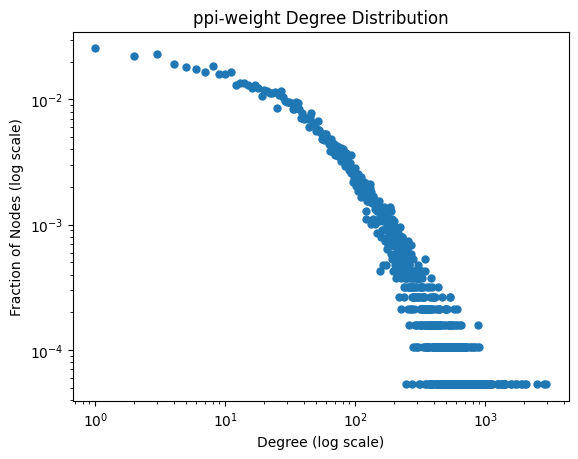

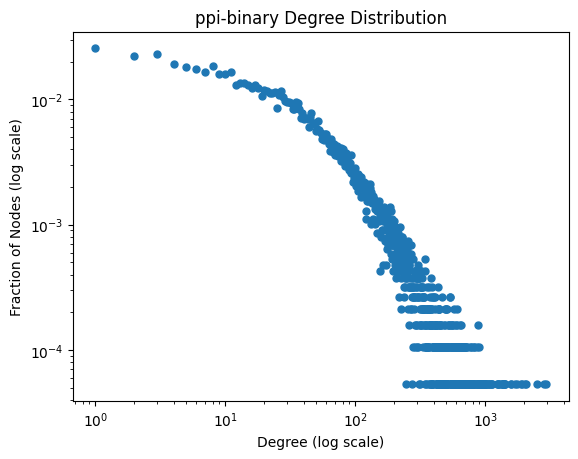

In [35]:
plot_degree_distribution('ppi-weight',G, use_weight=True)
plot_degree_distribution('ppi-binary',G, use_weight=False)

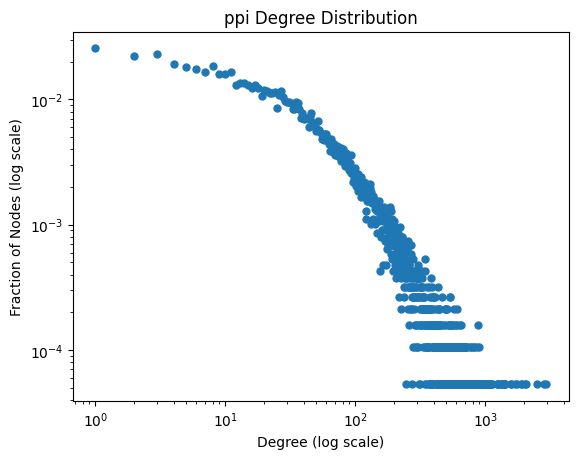

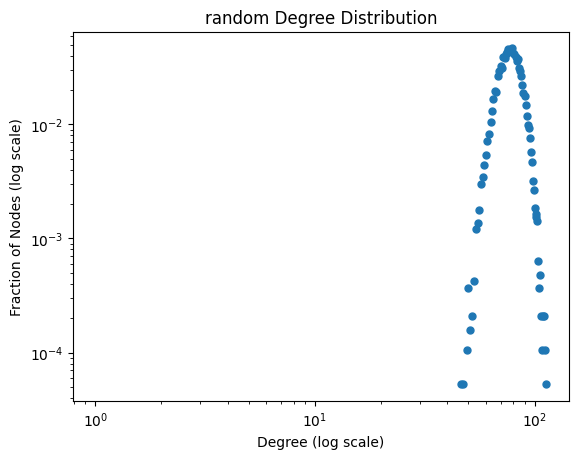

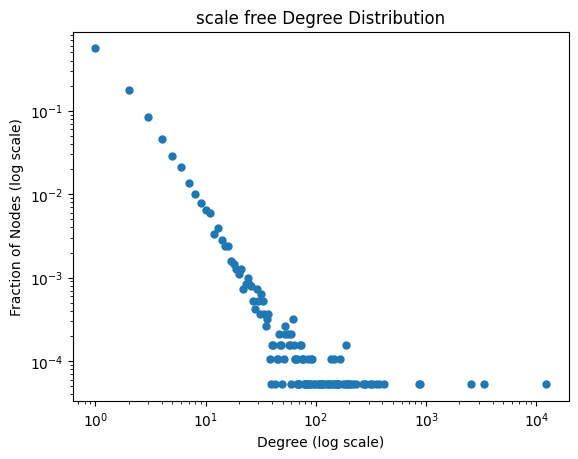

In [27]:
plot_degree_distribution('ppi',G, use_weight=False)
plot_degree_distribution('random',random_graph, use_weight=False)
plot_degree_distribution('scale free', scale_free_network, use_weight=False)

## load string db and get combined score ppi network

In [2]:
############### create mapped graph ppi 
local_stringdb = 'D:/study/thesis/project/HBDM-main/data/nn_data/stringdb/'
# load local STRING database and names
df = pd.read_csv(local_stringdb+'9606.protein.info.v12.0.txt', sep='\t', header=0, usecols=['#string_protein_id', 'preferred_name'])
df['preferred_name'] = df['preferred_name'].str.upper()
stringId2name = df.set_index('#string_protein_id')['preferred_name'].to_dict()
name2stringId = df.set_index('preferred_name')['#string_protein_id'].to_dict()
df = pd.read_csv(local_stringdb+'9606.protein.aliases.v12.0.txt', sep='\t', header=0, usecols=['#string_protein_id', 'alias']).drop_duplicates(['alias'], keep='first')
df['alias'] = df['alias'].str.upper()
aliases2stringId = df.set_index('alias')['#string_protein_id'].to_dict()
def convert_stringId(alias):
    try:
        stringId = name2stringId[alias]
    except:
        #print(alias, 'can\'t be converted by name2stringId! Now trying aliases2stringId.')
        try:
            stringId = aliases2stringId[alias]
        except:
            #print(alias, 'can\'t be converted by aliases2stringId! Now return None.')
            stringId = None
    #print(alias, stringId)
    return stringId

# #string_score_transform = lambda x: -np.log(x/1000)

# graph_df = pd.read_csv(local_stringdb+'9606.protein.physical.links.detailed.v12.0.txt', sep=' ', header=0).convert_dtypes().replace(0, float('nan'))
# #network['combined_score'] = network['combined_score'].apply(string_score_transform)

# graph_df = graph_df[['protein1', 'protein2','combined_score']]
# graph_df['protein1'] = graph_df['protein1'].str.replace('9606.ENSP', '')
# graph_df['protein2'] = graph_df['protein2'].str.replace('9606.ENSP', '')

# with open(r'D:\study\thesis\project\HBDM-main\data\datasets\ppi\ppi_index.pkl', 'rb') as f:
#     value_to_index_mapping = pickle.load(f)
# len(value_to_index_mapping)
# sub_graph_df = graph_df[['protein1', 'protein2']]
# sub_graph_array = np.array(sub_graph_df.to_numpy(), dtype=int)
# mapped_arr = np.vectorize(value_to_index_mapping.get)(sub_graph_array)
# graph_df['node1'] = mapped_arr.T[0]
# graph_df['node2'] = mapped_arr.T[1]
# graph_df.to_csv(r'D:\study\thesis\project\HBDM-main\data\graph_ppi.csv',index=False)

In [3]:
# graph_df = pd.read_csv(r'D:\study\thesis\project\HBDM-main\data\graph_ppi.csv')
graph_df = pd.read_csv(r'D:\study\thesis\project\HBDM-main\data\st_graph.csv')

In [7]:
len(graph_df[graph_df['coexp_value']==0])

57907

In [9]:
nozero_df = graph_df[graph_df['coexp_value']>=0]

In [8]:
graph_df['weight'] = graph_df['combined_score']*graph_df['coexp_value']

In [8]:
graph_df.sort_values(by='coexp_value',ascending=False)

,protein1,protein2,combined_score,node1,node2,coexp_value
66433,9606.ENSP00000224784,9606.ENSP00000358866,410,725,10051,0.810240
66415,9606.ENSP00000224784,9606.ENSP00000279022,907,725,3577,0.806181
719935,9606.ENSP00000346839,9606.ENSP00000358866,551,8427,10051,0.789668
1142027,9606.ENSP00000386786,9606.ENSP00000224784,392,13771,725,0.782103
66482,9606.ENSP00000224784,9606.ENSP00000376678,201,725,12560,0.781089
...,...,...,...,...,...,...
1516227,9606.ENSP00000501317,9606.ENSP00000297591,292,18766,4615,NaN
1516229,9606.ENSP00000501317,9606.ENSP00000444357,292,18766,16258,NaN
1516230,9606.ENSP00000501317,9606.ENSP00000296785,962,18766,4536,NaN
1516232,9606.ENSP00000501317,9606.ENSP00000370745,188,18766,12028,NaN


In [10]:
graph_df = graph_df.dropna()

In [10]:
nozero_df.dropna(inplace=True)

C:\Users\ZZY\AppData\Local\Temp\ipykernel_70516\894261229.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nozero_df.dropna(inplace=True)


In [11]:
nozero_df

,protein1,protein2,combined_score,node1,node2,coexp_value
1,9606.ENSP00000000233,9606.ENSP00000226004,161,0,776,0.077583
2,9606.ENSP00000000233,9606.ENSP00000434442,499,0,15878,0.036439
3,9606.ENSP00000000233,9606.ENSP00000262455,531,0,2413,0.051753
4,9606.ENSP00000000233,9606.ENSP00000303145,499,0,5074,0.074539
5,9606.ENSP00000000233,9606.ENSP00000263265,292,0,2543,0.036531
...,...,...,...,...,...,...
1516223,9606.ENSP00000501317,9606.ENSP00000248975,190,18766,1456,0.009225
1516224,9606.ENSP00000501317,9606.ENSP00000310490,292,18766,5680,0.000000
1516226,9606.ENSP00000501317,9606.ENSP00000222330,218,18766,649,0.003137
1516228,9606.ENSP00000501317,9606.ENSP00000340373,457,18766,7861,0.004705


In [87]:
# genetics = pd.read_csv(r'D:\study\thesis\project\HBDM-main\data\disease\Coronary artery disease.tsv',sep='\t')
genetics = pd.read_csv(r'D:\study\thesis\project\HBDM-main\data\disease\ASCVD.txt')

In [88]:
genetic_list = genetics['Gene'].tolist()
genetics_string = [convert_stringId(value) for value in genetic_list]

In [89]:
hitsdf = graph_df[(graph_df['protein1'].isin(genetics_string))&(graph_df['protein2'].isin(genetics_string))]

In [85]:
graph_df['coexp_value'].mean(),len(graph_df[graph_df['coexp_value'] == 0])/len(graph_df)

(0.03058303106540869, 0.10243659958676517)

In [86]:
hitsdf['coexp_value'].mean(),len(hitsdf[hitsdf['coexp_value'] == 0])/len(hitsdf)

(0.0399321941370122, 0.10418250950570342)

In [90]:
hitsdf['coexp_value'].mean(),len(hitsdf[hitsdf['coexp_value'] == 0])/len(hitsdf)

(0.05870677780347282, 0.035422343324250684)

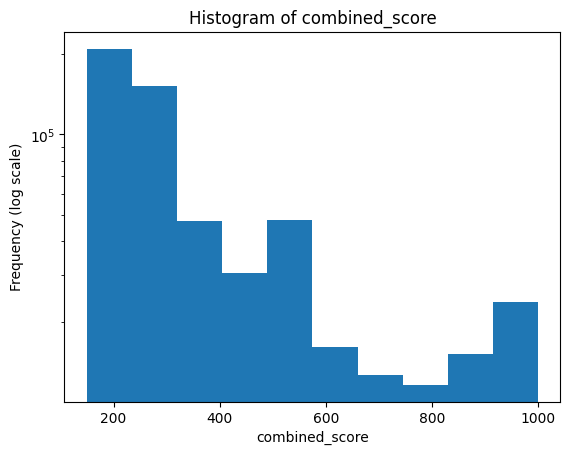

In [5]:
plt.hist(nozero_df['combined_score'], bins=10) 
plt.yscale('log')

# Add labels and title if needed
plt.xlabel('combined_score')
plt.ylabel('Frequency (log scale)')
plt.title('Histogram of combined_score')

plt.show()

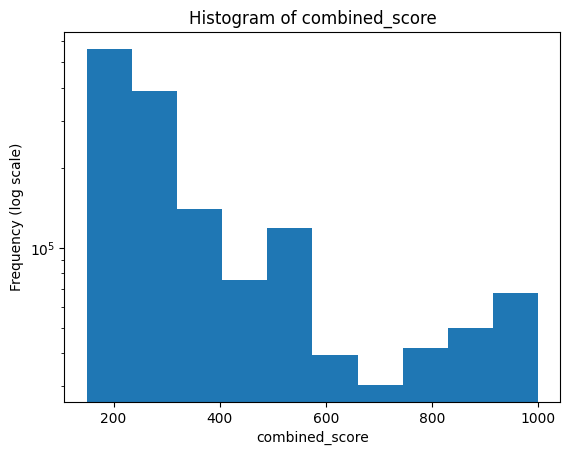

In [33]:
plt.hist(graph_df['combined_score'], bins=10) 
plt.yscale('log')

# Add labels and title if needed
plt.xlabel('combined_score')
plt.ylabel('Frequency (log scale)')
plt.title('Histogram of combined_score')

plt.show()

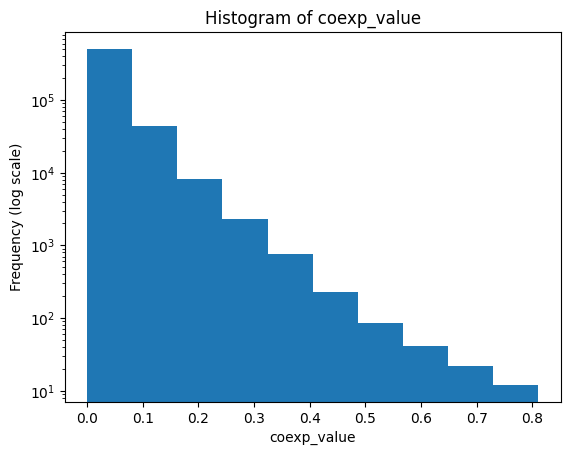

In [36]:
plt.hist(graph_df['coexp_value'], bins=10)  # You can adjust the number of bins as needed
plt.yscale('log')  # Set the y-axis scale to logarithmic

# Add labels and title if needed
plt.xlabel('coexp_value')
plt.ylabel('Frequency (log scale)')
plt.title('Histogram of coexp_value')

plt.show()

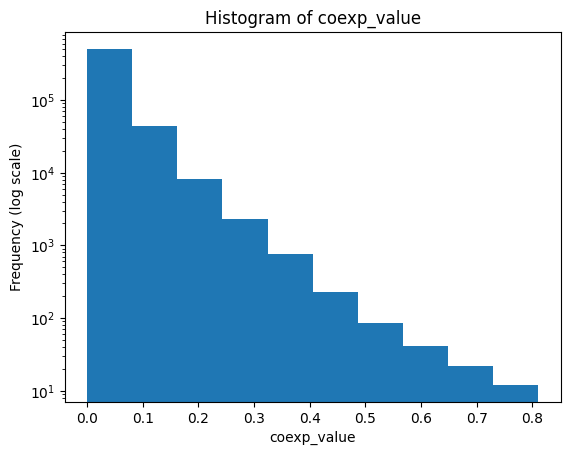

In [6]:
plt.hist(nozero_df['coexp_value'], bins=10)  # You can adjust the number of bins as needed
plt.yscale('log')  # Set the y-axis scale to logarithmic

# Add labels and title if needed
plt.xlabel('coexp_value')
plt.ylabel('Frequency (log scale)')
plt.title('Histogram of coexp_value')

plt.show()

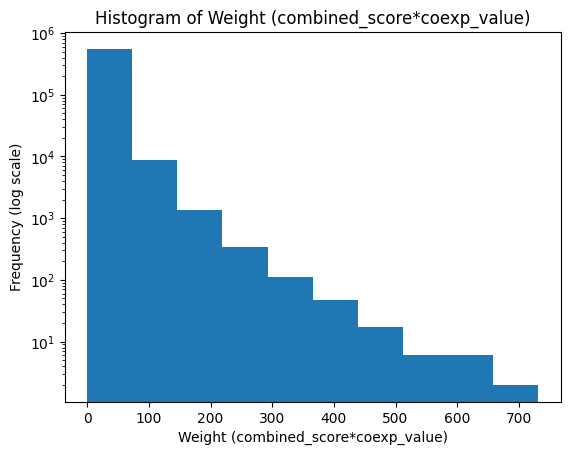

In [35]:
plt.hist(graph_df['weight'], bins=10)  # You can adjust the number of bins as needed
plt.yscale('log')  # Set the y-axis scale to logarithmic

# Add labels and title if needed
plt.xlabel('Weight (combined_score*coexp_value)')
plt.ylabel('Frequency (log scale)')
plt.title('Histogram of Weight (combined_score*coexp_value)')

plt.show()

In [11]:
graph_df.columns

Index(['protein1', 'protein2', 'combined_score', 'node1', 'node2',
       'coexp_value', 'weight'],
      dtype='object')

In [12]:
len(graph_df),len(graph_df.dropna(subset=['coexp_value']))

(565296, 565296)

In [13]:
len(graph_df[graph_df['coexp_value']==0])

57907

In [12]:
st_graph_df = graph_df.dropna(subset=['coexp_value'])
st_graph_df = st_graph_df[st_graph_df['coexp_value']!=0]

In [13]:
st_graph_df.head(3)

,protein1,protein2,combined_score,node1,node2,coexp_value
1,9606.ENSP00000000233,9606.ENSP00000226004,161,0,776,0.077583
2,9606.ENSP00000000233,9606.ENSP00000434442,499,0,15878,0.036439
3,9606.ENSP00000000233,9606.ENSP00000262455,531,0,2413,0.051753


In [15]:
proteins = sorted(list(set(st_graph_df['protein1'].tolist())|set(st_graph_df['protein2'].tolist())))

In [16]:
string2nodeidx = {value: index for index, value in enumerate(proteins)}

In [17]:
file_path = r'D:\study\thesis\project\HBDM-main\data\datasets\st_binary\ppi_index.pkl'

# Serialize and save the Tensor to the file
with open(file_path, 'wb') as file:
    pickle.dump(string2nodeidx, file)
# Close the file
file.close()

In [18]:
st_graph_df['node1']=st_graph_df['protein1'].map(string2nodeidx)
st_graph_df['node2']=st_graph_df['protein2'].map(string2nodeidx)

In [96]:
st_graph_df['coexp_bins'] = st_graph_df['coexp_value']*10
st_graph_df['coexp_bins'] = st_graph_df['coexp_bins'].astype(int)
st_graph_df

,protein1,protein2,combined_score,node1,node2,coexp_value,weight,coexp_bins
1,9606.ENSP00000000233,9606.ENSP00000226004,161,0,720,0.077583,12.490867,0
2,9606.ENSP00000000233,9606.ENSP00000434442,499,0,13772,0.036439,18.183118,0
3,9606.ENSP00000000233,9606.ENSP00000262455,531,0,2215,0.051753,27.480720,0
4,9606.ENSP00000000233,9606.ENSP00000303145,499,0,4603,0.074539,37.194834,0
5,9606.ENSP00000000233,9606.ENSP00000263265,292,0,2335,0.036531,10.667159,0
...,...,...,...,...,...,...,...,...
1516219,9606.ENSP00000501317,9606.ENSP00000305071,962,15840,4734,0.001476,1.419926,0
1516223,9606.ENSP00000501317,9606.ENSP00000248975,190,15840,1339,0.009225,1.752768,0
1516226,9606.ENSP00000501317,9606.ENSP00000222330,218,15840,604,0.003137,0.683764,0
1516228,9606.ENSP00000501317,9606.ENSP00000340373,457,15840,6970,0.004705,2.150092,0


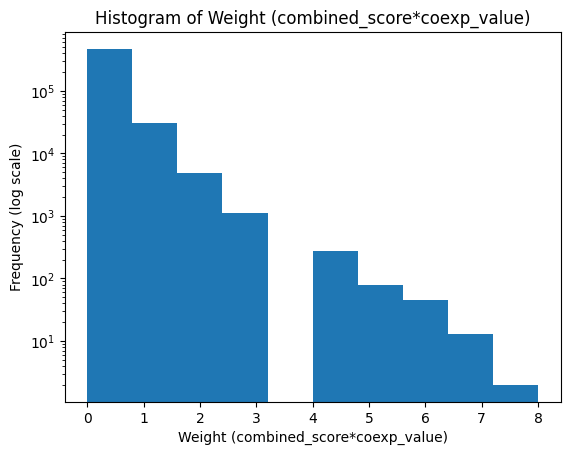

In [97]:
plt.hist(st_graph_df['coexp_bins'], bins=10)  # You can adjust the number of bins as needed
plt.yscale('log')  # Set the y-axis scale to logarithmic

# Add labels and title if needed
plt.xlabel('Weight (combined_score*coexp_value)')
plt.ylabel('Frequency (log scale)')
plt.title('Histogram of Weight (combined_score*coexp_value)')

plt.show()

In [20]:
st_graph_df.columns

Index(['protein1', 'protein2', 'combined_score', 'node1', 'node2',
       'coexp_value'],
      dtype='object')

In [21]:
# G = nx.from_pandas_edgelist(graph_df, source='node1', target='node2', edge_attr='coexp_bins', create_using=nx.Graph)
G = nx.from_pandas_edgelist(st_graph_df, source='node1', target='node2', edge_attr='combined_score', create_using=nx.Graph)

In [22]:
len(G.nodes)

15841

In [13]:
edges = np.array([(u, v, data['combined_score']) for u, v, data in G.edges(data=True)])

# Determine i, j, and weights
i = np.where(edges[:, 0] > edges[:, 1], edges[:, 1], edges[:, 0])
j = np.where(edges[:, 0] > edges[:, 1], edges[:, 0], edges[:, 1])
weights = edges[:, 2]
weights = weights*0.01

root = 'D:/study/thesis/project/HBDM-main/data/datasets/ppi/'
np.savetxt(root+'sparse_i.txt', np.array(i), delimiter='\n')
np.savetxt(root+'sparse_j.txt', np.array(j), delimiter='\n')
np.savetxt(root+'sparse_w.txt', np.array(weights), delimiter='\n')


In [18]:
weights = (weights*0.01).astype(int)
np.savetxt(root+'sparse_10.txt', np.array(weights), delimiter='\n')

In [15]:
level_edges = dict()
for u, v, data in G.edges(data=True):
    level = int(str(data['combined_score'])[0])
    if level in level_edges:
        level_edges[level].append([u, v])
    else:
        level_edges[level]=[[u, v]]

for level in level_edges:
    edges = np.array(level_edges[level])
    sparse_i = np.where(edges[:, 0] > edges[:, 1], edges[:, 1], edges[:, 0])
    sparse_j = np.where(edges[:, 0] > edges[:, 1], edges[:, 0], edges[:, 1])
    np.savetxt(root+'level_'+str(level)+'_sparse_i.txt', np.array(sparse_i), delimiter='\n')
    np.savetxt(root+'level_'+str(level)+'_sparse_j.txt', np.array(sparse_j), delimiter='\n')